In [1]:
import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)
import requests
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import random
import numpy as np
import pandas as pd
import itertools
from sklearn import svm
from sklearn import tree
from urllib import request
from random import randint
#from wordcloud import WordCloud
from nltk import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
import gensim
from gensim.models import LdaModel, Word2Vec
import pyLDAvis
import pyLDAvis.gensim_models
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from nltk.corpus import stopwords
from sklearn import preprocessing
from nltk.stem import WordNetLemmatizer
#!pip install mlxtend
#from mlxtend.evaluate import bias_variance_decomp
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection  import cross_val_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import silhouette_samples, silhouette_score, homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hadyo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hadyo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hadyo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#fitting KMeans model
def model_kmeans(data):
    kmeans = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    y_data = kmeans.fit_predict(data)
    return y_data, kmeans

In [3]:
def plotting(features, y_pred, model, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(features[y_pred == 0, 0],
                features[y_pred == 0, 1], marker = "x", c = 'red', s = 100, label = ['c1'])
    plt.scatter(features[y_pred == 1, 0],
                features[y_pred == 1, 1], marker = "x", c = 'blue', s = 100, label = ['c2'])
    plt.scatter(features[y_pred == 2, 0],
                features[y_pred == 2, 1], marker = "x", c = 'orange', s = 100, label = ['c3'])
    plt.scatter(features[y_pred == 3, 0],
                features[y_pred == 3, 1], marker = "x", c = 'yellow', s = 100, label = ['c4'])
    plt.scatter(features[y_pred == 4, 0],
                features[y_pred == 4, 1], marker = "x", c = 'green', s = 100, label = ['c5'])
    plt.scatter(model.cluster_centers_[:,0],
                model.cluster_centers_[:,1], marker = "o", c = 'black', label = 'centroids')
    plt.legend()
    plt.title(title)

In [4]:
#evaluate the clusters
def clustering_evaluation(features, clustering_labels, data):
    print("Homogeneity: {}".format(homogeneity_score(data, clustering_labels)))
    print("Completeness: {}".format(completeness_score(data, clustering_labels)))
    print("V-measure: {}".format(v_measure_score(data, clustering_labels)))
    print("Adjusted Rand-Index: {}".format(adjusted_rand_score(data, clustering_labels)))
    print("Silhouette Coefficient: {}".format(silhouette_score(features, clustering_labels)))


In [5]:
#books_url_list = ["https://www.gutenberg.org/files/19719/19719-0.txt",
 #                 "https://www.gutenberg.org/cache/epub/28434/pg28434.txt",
  #                "https://www.gutenberg.org/cache/epub/15147/pg15147.txt",
   #               "https://www.gutenberg.org/cache/epub/17866/pg17866.txt",
    #              "https://www.gutenberg.org/files/3772/3772-0.txt"]

In [6]:
books_url_list = ["https://www.gutenberg.org/files/84/84-0.txt",
                  "https://www.gutenberg.org/cache/epub/28434/pg28434.txt",
                  "https://www.gutenberg.org/cache/epub/3623/pg3623.txt",
                  "https://www.gutenberg.org/cache/epub/17866/pg17866.txt",
                  "https://www.gutenberg.org/files/3772/3772-0.txt"]

# Preprocessing

In [7]:
#function read raw data
def read_books(url):
    files = []
    for i in url:
        file = requests.get(url = i)
        files.append(file.content.decode('utf-8'))
    return files

#read raw data
raw_dataset = read_books(books_url_list)
len(raw_dataset)

5

In [8]:
#Function cleaned tokens
def cleaned_text(raw_text):
    text_beg = raw_text.find("*** START OF")
    text_end = raw_text.find("*** END OF")

    raw_text = raw_text[text_beg : text_end]
    raw_text = re.findall(r"[a-zA-Z]+", raw_text)
    raw_text = " ".join(raw_text).lower()
    tokens = word_tokenize(raw_text)
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    return tokens
#Getting cleaned tokens
tokens = []
for i in range(len(raw_dataset)):
    tokens.append(cleaned_text(raw_dataset[i]))
len(tokens)

5

In [9]:
#function to extract author name, book name and labels
def extract_book_author(raw_text, index):
    label = chr(index + 97)
        
    title_beg = raw_text.find("Title") + 7
    title_end = raw_text.find("\r\n\r\nAuthor")
    title = raw_text[title_beg : title_end]

    author_beg = raw_text.find("Author") + 8
    c = 0
    while raw_text[author_beg + c] != "\r":
        c += 1
        author_end = author_beg + c
    author = raw_text[author_beg : author_end]
    return label, title, author

#getting the author name, book name, labels
label, author, title = [], [], []
for i in range(len(raw_dataset)):
    label_temp, title_temp, author_temp = extract_book_author(raw_dataset[i],i)
    label.append(label_temp)
    author.append(author_temp)
    title.append(title_temp)
    
print(len(label))
print(len(author))
print(len(title))
print(len(tokens))

5
5
5
5


In [10]:
#function to partition data
def partitioned_text(tokens, title, author, label):
    book_partitions = []
    for i in range(0, len(tokens) -150, 150):
        partition = [" ".join(tokens[i : i + 150]), title, author, label]
        book_partitions.append(partition)
    return book_partitions

In [11]:
partitions = []
for i in range(len(books_url_list)):
    book_partitions = partitioned_text(tokens[i], title[i], author[i], label[i])
    random.shuffle(book_partitions)
    book_partitions = book_partitions[0:200]
    partitions += book_partitions

dataset = pd.DataFrame(partitions, columns = ["partitions", "title", "author", "label"])
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset

,partitions,title,author,label
0,eos dawn cainos recent fossil shell period con...,The Student’s Elements of Geology,Sir Charles Lyell,e
1,let rustle drink returned stephen gresham came...,Murder in the Gunroom,Henry Beam Piper,d
2,often inclined occasionally even nearly tangen...,The Astronomy of Milton's 'Paradise Lost',Thomas Orchard,b
3,still alive well thanks mick case getting tigh...,Murder in the Gunroom,Henry Beam Piper,d
4,included formerly mr woodward norwich series a...,The Student’s Elements of Geology,Sir Charles Lyell,e
...,...,...,...,...
995,maquis hell last thing want said want try real...,Murder in the Gunroom,Henry Beam Piper,d
996,good idea actual practice walter went hall doo...,Murder in the Gunroom,Henry Beam Piper,d
997,belong pure alumine apparently combination sub...,The Student’s Elements of Geology,Sir Charles Lyell,e
998,stood vast infinitude confined till second bid...,The Astronomy of Milton's 'Paradise Lost',Thomas Orchard,b


# Feature Engineering

## BOW model

In [12]:
def model_BOW(data): # take the partitions
    cv = CountVectorizer()
    cv_fit = cv.fit_transform(data)
    cv_fit_df = pd.DataFrame(cv_fit.toarray(), columns = cv.get_feature_names())
    return cv_fit_df
    
bow_vectorizer = model_BOW(dataset['partitions'])
bow_vectorizer

,aah,aargau,aaron,aarvo,abandon,abandoned,abated,abatement,abb,abbeville,...,zone,zonites,zoological,zoologist,zoophyte,zorger,zu,zulu,zululand,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TF-IDF model

In [13]:
def model_TFIDF(data): # take the partitions
    tfIdf = TfidfVectorizer(use_idf=True)
    tfidf_fit = tfIdf.fit_transform(data).toarray()
    tfidf_fit_df = pd.DataFrame(tfidf_fit, columns = tfIdf.get_feature_names())
    return tfidf_fit_df

tfidf_vectorizer = model_TFIDF(dataset['partitions'])
tfidf_vectorizer

,aah,aargau,aaron,aarvo,abandon,abandoned,abated,abatement,abb,abbeville,...,zone,zonites,zoological,zoologist,zoophyte,zorger,zu,zulu,zululand,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.068163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## LDA as a feature extractor

In [14]:
def model_LDA2(data): # take the partitions
    cv = CountVectorizer(max_df = 0.9, min_df = 2)
    dtm = cv.fit_transform(data)
    lda = LatentDirichletAllocation(n_components = 5, random_state = 5)
    lda = lda.fit_transform(dtm)
    return lda

lda = model_LDA2(dataset['partitions'])
lda

array([[0.99408745, 0.00147998, 0.00148116, 0.00147752, 0.0014739 ],
       [0.00141767, 0.00142919, 0.99429968, 0.00142421, 0.00142925],
       [0.79314078, 0.01178107, 0.00141199, 0.19224787, 0.00141829],
       ...,
       [0.95557519, 0.00138526, 0.00140564, 0.00138387, 0.04025004],
       [0.00139821, 0.0014    , 0.00139   , 0.99441892, 0.00139287],
       [0.00140591, 0.0014156 , 0.99435487, 0.00141115, 0.00141248]])

## wordembedding model

In [15]:
#splitting the sentences in each partitoin
partitions_splitted = []
for partition in dataset['partitions']:
    temp = partition.split()
    partitions_splitted.append(temp)


In [16]:
#creating the word2vec model
def model_word2vec(tokens_data): # take the partitions_splitted
    model = Word2Vec(sentences = tokens_data, vector_size = 150, workers = 6)
    return model

In [17]:
word2vec_model = model_word2vec(partitions_splitted)
word2vec_model

In [18]:
#Create the word document vectors
def doc_vectors(data_tokens, word2vec_model):
    features = []
    for tokens in data_tokens:
        zero_vector = np.zeros(word2vec_model.vector_size)
        vectors = []
        for token in tokens:
            if token in word2vec_model.wv:
                vectors.append(word2vec_model.wv[token])
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis = 0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

vectorized_doc = doc_vectors(partitions_splitted, word2vec_model) #vectorized documents


In [19]:
len(vectorized_doc), len(vectorized_doc[0])

(1000, 150)

## KMeans + BOW

In [20]:
bow_features_reduced = KernelPCA(n_components = 2, eigen_solver = 'dense').fit_transform(bow_vectorizer)

In [26]:
#fitting the model with the bow
y_data_kmeans_bow, model_kmeans_bow = model_kmeans(bow_features_reduced)


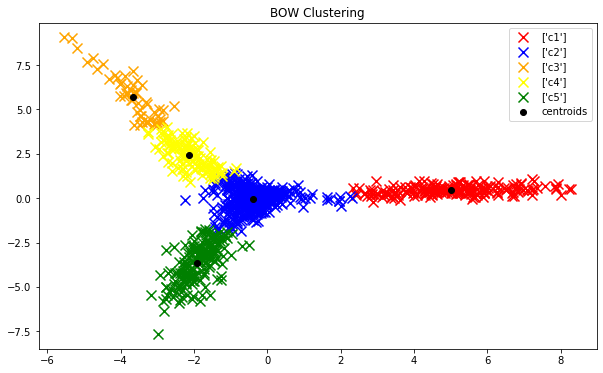

In [27]:
plotting(bow_features_reduced, y_data_kmeans_bow, model_kmeans_bow, 'BOW Clustering')

In [28]:
clustering_evaluation(bow_features_reduced, model_kmeans_bow.labels_, dataset['label'])

Homogeneity: 0.6570702062679732
Completeness: 0.7624409866565428
V-measure: 0.7058447427067405
Adjusted Rand-Index: 0.5485854420048407
Silhouette Coefficient: 0.625823356761998


## KMeans + TFIDF

In [29]:
bow_features_reduced_tfidf = KernelPCA(n_components = 2, eigen_solver = 'dense').fit_transform(tfidf_vectorizer)

In [32]:
#fitting KMeans model with the TFIDF
y_data_kmeans_tfidf, model_kmeans_tfidf = model_kmeans(bow_features_reduced_tfidf)

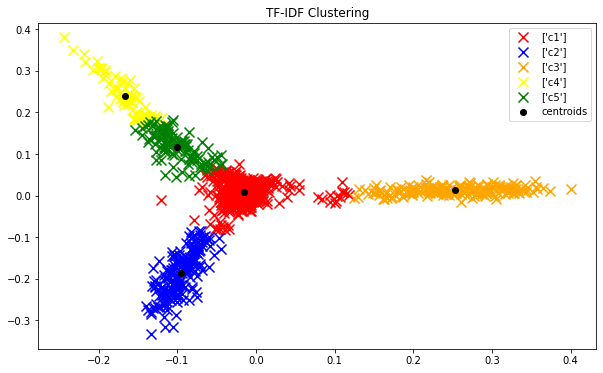

In [33]:
plotting(bow_features_reduced_tfidf, y_data_kmeans_tfidf, model_kmeans_tfidf, 'TF-IDF Clustering')

In [34]:
clustering_evaluation(bow_features_reduced_tfidf, model_kmeans_tfidf.labels_, dataset['label'])

Homogeneity: 0.6919046580056981
Completeness: 0.7883313580550788
V-measure: 0.7369772560214091
Adjusted Rand-Index: 0.5870744123444512
Silhouette Coefficient: 0.6380329122435936


## KMeans + LDA

In [35]:
bow_features_reduced_lda = KernelPCA(n_components = 2, eigen_solver = 'dense').fit_transform(lda)

In [36]:
#fitting KMeans model with the LDA
y_data_kmeans_lda, model_kmeans_lda = model_kmeans(bow_features_reduced_lda)

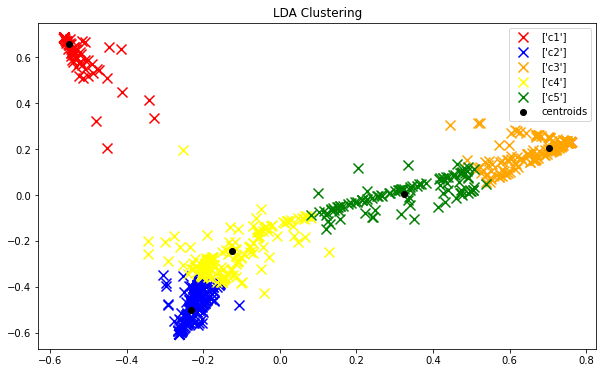

In [37]:
plotting(bow_features_reduced_lda, y_data_kmeans_lda, model_kmeans_lda, 'LDA Clustering')

In [38]:
clustering_evaluation(bow_features_reduced_lda, model_kmeans_lda.labels_, dataset['label'])

Homogeneity: 0.6660315602115103
Completeness: 0.6829324062074036
V-measure: 0.6743761098864892
Adjusted Rand-Index: 0.5706480060821765
Silhouette Coefficient: 0.6467005879009086


## KMeans + wordEmbedding

In [39]:
bow_features_reduced_we = KernelPCA(n_components = 2, eigen_solver = 'dense').fit_transform(vectorized_doc)

In [40]:
#fitting KMeans model with the LDA
y_data_kmeans_we, model_kmeans_we = model_kmeans(bow_features_reduced_we)

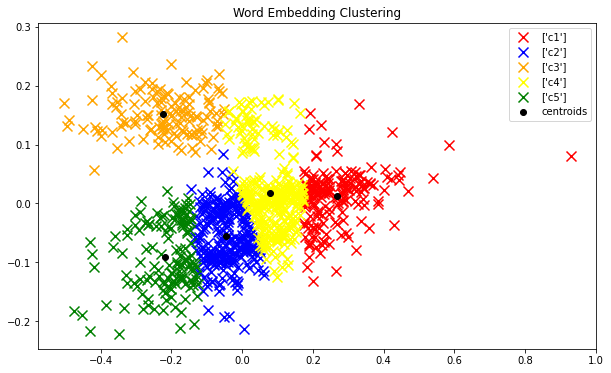

In [41]:
plotting(bow_features_reduced_we, y_data_kmeans_we, model_kmeans_we, 'Word Embedding Clustering')

In [42]:
clustering_evaluation(bow_features_reduced_we, model_kmeans_we.labels_, dataset['label'])

Homogeneity: 0.2134786930811494
Completeness: 0.22107845218659927
V-measure: 0.21721211838373736
Adjusted Rand-Index: 0.12835258071351813
Silhouette Coefficient: 0.37303677201271057
